# Simulation with measured or predicted thrust

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, track_plots, plot
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
#from vessel_manoeuvring_models.models.vmm_martin_simple import martins_simple_model as vmm
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, ModelSimulatorWithPropeller
from vessel_manoeuvring_models.models.propeller import *
from vessel_manoeuvring_models.prime_system import df_prime
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from vessel_manoeuvring_models.models.diff_eq_to_matrix import DiffEqToMatrix
from sklearn.metrics import r2_score
import statsmodels.api as sm
import logging
log = logging.getLogger(__name__)

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
import anyconfig
globals_path = "../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]

In [4]:
%reload_kedro
ship='wPCC'
time_series = catalog.load(f"{ship}.time_series")
time_series_smooth = catalog.load(f"{ship}.time_series_preprocessed.ek_smooth")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")
time_series_meta_data.index = time_series_meta_data.index.astype(str)
time_series_meta_data.rename(columns={'test_type':'test type'}, inplace=True)
model_loader = catalog.load(f"{ship}.models")
#time_series_meta_data.rename(columns={'test_type':'test type'}, inplace=True)

[05/25/23 17:50:24] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=384671;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=629594;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[05/25/23 17:50:24] INFO     Kedro project phd                                                      ]8;id=647055;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=647256;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=998750;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=93612;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=601889;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=673367;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from 'wPCC.time_series' (PartitionedDataSet)...       ]8;id=939120;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=314032;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.time_series_preprocessed.ek_smooth'        ]8;id=290363;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=527775;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=19883;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=154185;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:wPCC.exclude_parameters'                 ]8;id=575729;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=39539;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=869814;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=875129;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.models' (PartitionedDataSet)...            ]8;id=589015;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=116090;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [5]:
data = time_series_smooth['wpcc.updated.22773.ek_smooth']()
data['V'] = data['U'] = np.sqrt(data['u']**2 + data['v']**2)
data['rev'] = data[['Prop/SB/Rpm', 'Prop/PS/Rpm']].mean(axis=1)
g_=9.81
data['g'] = g_

In [6]:
model = model_loader['wpcc.updated.vmm_martins_simple.joined.model']()

<Axes: title={'center': 'Track plot'}, xlabel='$y_0$ $[m]$', ylabel='$x_0$ $[m]$'>

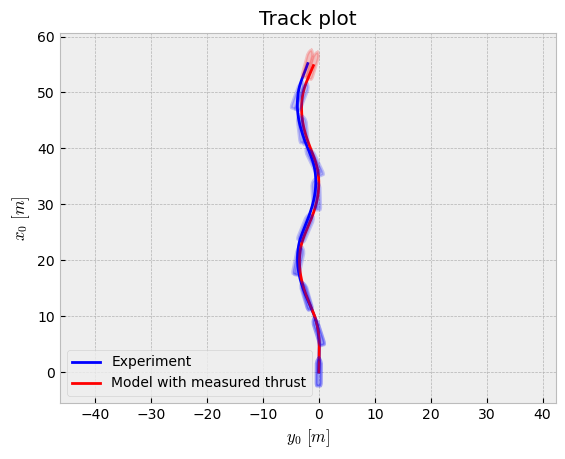

In [7]:
result_with_measured_thrust = model.simulate(data)

dataframes = {'Experiment':data,
              'Model with measured thrust':result_with_measured_thrust.result,
             }
track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], N=10)


## Thrust prediction model

In [8]:
C0_w_p0,C1_w_p0,F_n = sp.symbols("C0_w_p0, C1_w_p0,F_n")
eq_w_p0 = sp.Eq(w_p0, C0_w_p0 + C1_w_p0*F_n)
eq_w_p0

Eq(w_p0, C0_w_p0 + C1_w_p0*F_n)

Assuming that $w_{p0}$ is a good model:

In [9]:
eq_F_n = sp.Eq(F_n,U/sp.sqrt(L*g))
eq_F_n

Eq(F_n, U/sqrt(L*g))

In [10]:
eq_w_p0 = eq_w_p0.subs(F_n, eq_F_n.rhs)
eq_w_p0

Eq(w_p0, C0_w_p0 + C1_w_p0*U/sqrt(L*g))

In [11]:
eq_w_p = eq_w_p0.subs(w_p0,w_p)
eq_w_p

Eq(w_p, C0_w_p0 + C1_w_p0*U/sqrt(L*g))

In [12]:
eqs = [eq_T,eq_K_T, eq_J, eq_w_p]
solution = sp.solve(eqs, thrust, K_T, J, w_p, dict=True)
eq = sp.Eq(thrust,solution[0][thrust])
eq

Eq(thrust, D**2*rho*(C0_w_p0**2*L*g*k_2*u**2 + 2*C0_w_p0*C1_w_p0*U*k_2*u**2*sqrt(L*g) - C0_w_p0*D*L*g*k_1*rev*u - 2*C0_w_p0*L*g*k_2*u**2 + C1_w_p0**2*U**2*k_2*u**2 - C1_w_p0*D*U*k_1*rev*u*sqrt(L*g) - 2*C1_w_p0*U*k_2*u**2*sqrt(L*g) + D**2*L*g*k_0*rev**2 + D*L*g*k_1*rev*u + L*g*k_2*u**2)/(L*g))

In [13]:
lambda_thrust = lambdify(eq.rhs)

In [14]:
params = {'C0_w_p0': 0.10378571428571445,
 'C1_w_p0': 0.24690520231438584,
 'k_0': 1.134275383834787,
 'k_1': -0.6937541478017938,
 'k_2': -0.17441181653424412}
data_predict_w0 = data.copy()
data_predict_w0['thrust'] = run(function=lambda_thrust, inputs=data_predict_w0, **ship_data, **params)

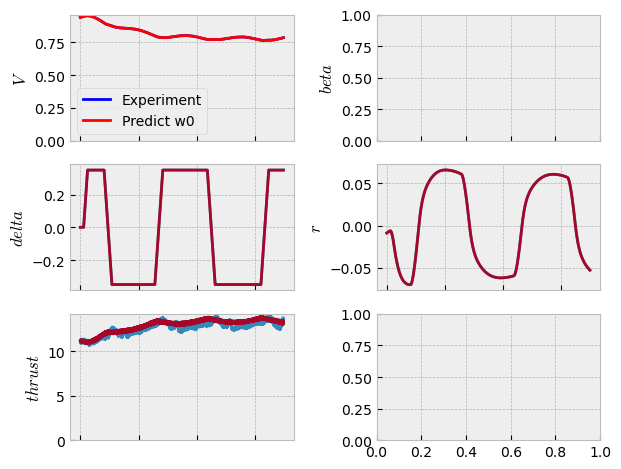

In [15]:
dataframes={'Experiment':data,
           'Predict w0': data_predict_w0,
           }
plot(dataframes=dataframes, keys=['thrust','V','beta','r','delta']);

## Add the thrust prediction to the simulation model

In [34]:
parameters = dict(model.parameters.copy())
parameters.update(params)
parameters['g'] = g_

model_with_propeller = ModelSimulatorWithPropeller(simulator=model, 
                                                   parameters=parameters, 
                                                   ship_parameters=model.ship_parameters, 
                                                   prime_system=model.prime_system, 
                                                   lambda_thrust=lambda_thrust)
model_with_propeller.parameters = parameters
#model_with_propeller.parameters['C0_w_p0'] = 0.5
#model_with_propeller.ship_parameters['g'] = g_

In [35]:
model_with_propeller.parameters

{'Xudot': 0.00017880704448812042,
 'Xdeltadelta': -0.0028938493416588626,
 'Xrr': -0.001477443533086129,
 'Xthrust': 0.883,
 'Xuu': 0.019964384825176533,
 'Xu': -0.020788384056439558,
 'Xvr': -0.007750206126939848,
 'Yrdot': -0.00030313777458141895,
 'Yvdot': -0.006109387408263365,
 'Ydelta': 0.004123480810726398,
 'Yr': 0.06468560811461845,
 'Ythrust': 0.0,
 'Yu': -2.6944497887175097e-05,
 'Yv': -0.020337960905936002,
 'Ythrustdelta': 0.009267670890407283,
 'Yur': -0.06607790538885408,
 'Yvvdelta': 0.03962720492434507,
 'Nrdot': -0.00029867482773178765,
 'Nvdot': -0.00012825440172375716,
 'Ndelta': -0.0019917770008379505,
 'Nr': -0.03748722396474311,
 'Nthrust': 0.0,
 'Nu': -3.481857149661811e-06,
 'Nv': -5.288155770188559e-05,
 'Nthrustdelta': -0.004476590186337452,
 'Nur': 0.03567323755395262,
 'Nvvdelta': -0.019141244739271316,
 'C0_w_p0': 0.10378571428571445,
 'C1_w_p0': 0.24690520231438584,
 'k_0': 1.134275383834787,
 'k_1': -0.6937541478017938,
 'k_2': -0.17441181653424412,
 'g'

In [36]:
data_ = data.drop(columns=['thrust'])
result_with_predicted_thrust = model_with_propeller.simulate(data_)

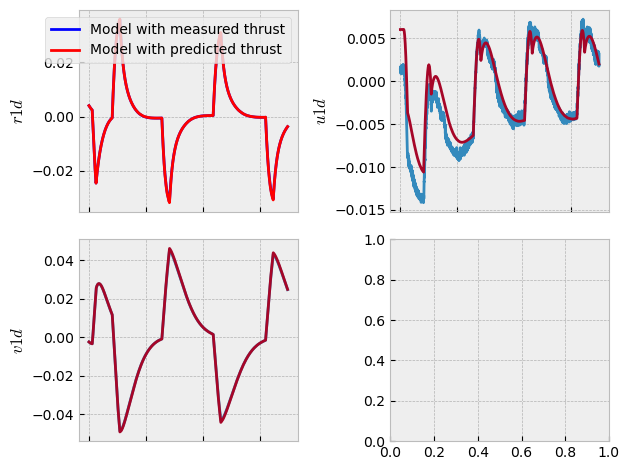

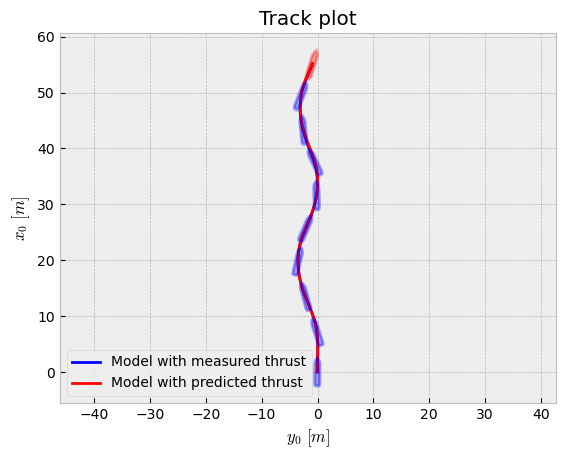

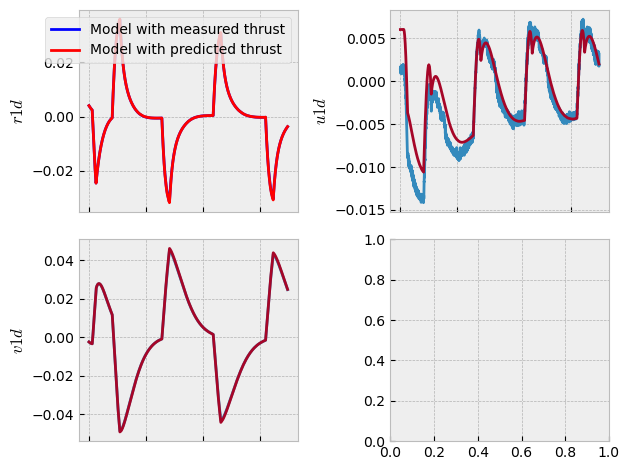

In [37]:
dataframes = {#'Experiment':data,
              'Model with measured thrust':result_with_measured_thrust.result,
              'Model with predicted thrust':result_with_predicted_thrust.result,
             }
track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], N=10)
plot(dataframes,keys=['u1d','v1d','r1d'])